In [1]:
# Import everything
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformer
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

#download datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

#load
trainloader = DataLoader(trainset, batch_size=1024, shuffle=True)
testloader = DataLoader(testset, batch_size=1024, shuffle=False)


train_images, train_labels = next(iter(trainloader))
test_images, test_labels = next(iter(testloader))

# Flatten the images and move to device
train_images_flattened = train_images.view(train_images.size(0), -1).to(device)
test_images_flattened = test_images.view(test_images.size(0), -1).to(device)
train_labels, test_labels = train_labels.to(device), test_labels.to(device)

/home/jtlumpk/.local/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
# reduce dimensions SVD
def reduce_dimensions(data, k=50):
    U, S, V = torch.svd(data.t())
    return torch.mm(data, U[:, :k]).to(device)

In [4]:
# Parameters for dimensionality reduction
k = 50
train_reduced = reduce_dimensions(train_images_flattened, k)
test_reduced = reduce_dimensions(test_images_flattened, k)

In [5]:
# Modal Define
class DNN(nn.Module):
    def __init__(self, input_size, num_classes=10):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [6]:
# Function to train and evaluate the model
def train_and_evaluate(epochs=48, save_interval=3, num_initializations=8):
    all_losses = []
    all_fc1_weights = []  # To store fc1 weights for each initialization

    for init in range(num_initializations):
        print(f"init: {init+1}")
        model = DNN(k).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        losses = []
        fc1_weights = []  

        for epoch in range(epochs):
            #print(f"Epoch: {epoch+1}")
            model.train()
            optimizer.zero_grad()
            outputs = model(train_reduced)
            loss = criterion(outputs, train_labels)
            loss.backward()
            optimizer.step()

            if epoch % save_interval == 0 or epoch == epochs - 1:

                losses.append(loss.item())
                fc1_weight_current = model.fc1.weight.data.cpu().numpy().flatten()
                fc1_weights.append(fc1_weight_current)

        all_losses.append(losses)
        all_fc1_weights.append(fc1_weights) 
    
    return all_losses, all_fc1_weights

init: 1
init: 2
init: 3
init: 4
init: 5
init: 6
init: 7
init: 8


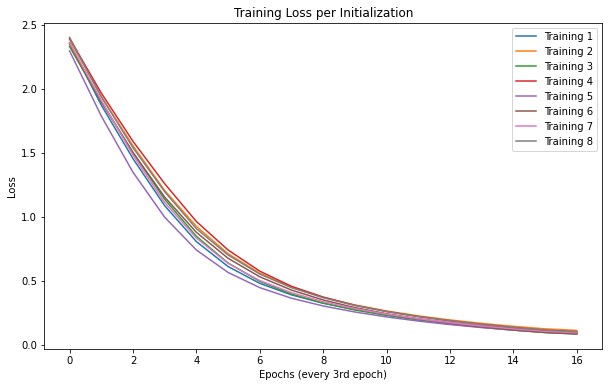

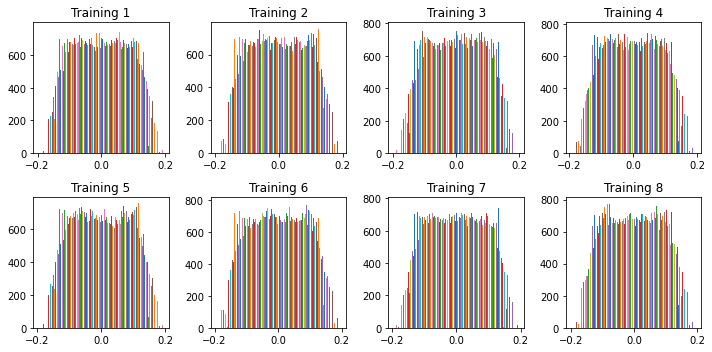

In [11]:
# Plotting function
def plot_losses(losses):
    plt.figure(figsize=(10, 6))
    for i, loss in enumerate(losses):
        plt.plot(range(len(loss)), loss, label=f'Training {i+1}')
    plt.xlabel('Epochs (every 3rd epoch)')
    plt.ylabel('Loss')
    plt.title('Training Loss per Initialization')
    plt.legend()
    plt.show()

# Train the model and plot the losses
losses, all_fc1_weights = train_and_evaluate(epochs=48, save_interval=3, num_initializations=8)
plot_losses(losses)


# Plotting the FC1 layer weights for each training session
plt.figure(figsize=(10, 5))
for i, weights in enumerate(all_fc1_weights):
    plt.subplot(2, 4, i+1)
    plt.hist(weights, bins=50)
    plt.title(f'Training {i+1}')
plt.tight_layout()
plt.show()